✓ Config Loaded

=== 1. DYNAMIC DATA LOADING ===
📂 พบไฟล์ทั้งหมด 3 ไฟล์:
  -> Loaded: final_moving_avg_devID109_test_prepared.csv (2535 rows)
  -> Loaded: label_for_dev109_test_prepared copy.csv (6566 rows)
  -> Loaded: moving_avg_for_train_prepared.csv (18222 rows)

🎉 MERGED SUCCESS! Total Data: (27323, 28)
Columns: ['timestamp', 'devID', 'temp', 'humi', 'soil', 'rain', 'geo', 'rain_ma_1h', 'rain_ma_6h', 'rain_ma_12h', 'rain_ma_24h', 'soil_ma_4h', 'soil_ma_8h', 'soil_ma_12h', 'soil_ma_16h', 'geo_ma_2min', 'geo_ma_4min', 'geo_ma_6min', 'geo_ma_8min', 'label', 'lat', 'long', 'risk', 'iso risk', 'lstm risk', 'rf risk', 'soil_diff_1h', 'geo_diff_30min']

=== 2. PREPROCESSING ===
Features: ['rain', 'soil', 'temp', 'humi', 'geo', 'rain_cum_24h', 'rain_cum_3d', 'soil_rate', 'geo_abs']

=== 3. SEQUENCE GENERATION ===
Total Sequences: (12442, 30, 9)

=== 4. SPLIT & BALANCE ===
Train: 8708 | Val: 1867 | Test: 1867
Scaler Saved.
Weights: {np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0


=== EVALUATION (Standard Argmax) ===

>>> VALIDATION SET RESULTS <<<
Accuracy: 0.9448

Confusion Matrix:
[[1673   71    9]
 [   4   47   15]
 [   0    4   44]]

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.95      0.98      1753
     Warning       0.39      0.71      0.50        66
    Critical       0.65      0.92      0.76        48

    accuracy                           0.94      1867
   macro avg       0.68      0.86      0.74      1867
weighted avg       0.97      0.94      0.95      1867


>>> TEST SET RESULTS <<<
Accuracy: 0.9384

Confusion Matrix:
[[1659   79   15]
 [   0   50   16]
 [   0    5   43]]

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.95      0.97      1753
     Warning       0.37      0.76      0.50        66
    Critical       0.58      0.90      0.70        48

    accuracy                           0.94      1867
   macro avg       0.

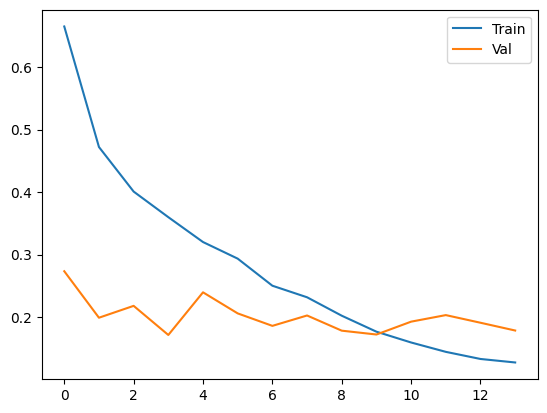

In [2]:
# %%
"""
=========================================================================================
PROJECT: LANDSLIDE DETECTION - DYNAMIC MULTI-FILE DATASET
โครงการ: ระบบตรวจจับดินถล่ม (รองรับการรวมไฟล์ CSV อัตโนมัติแบบไม่จำกัดจำนวน)
=========================================================================================

[WORKFLOW]
1. AUTO-MERGE: สแกนหาไฟล์ .csv ทั้งหมดในโฟลเดอร์ที่กำหนด แล้วจับรวมร่างเป็นก้อนเดียว
2. CLEANING: ปรับชื่อ Column ให้ตรงกันอัตโนมัติ (แม้ไฟล์จะตั้งชื่อหัวตารางมาไม่เหมือนกัน)
3. PIPELINE: Resample -> Physics Features -> Sequence -> Split -> Train -> Standard Predict

"""

# %%
# ====================================================================
# 1. CONFIGURATION
# ====================================================================
import os
import glob
import re
import random
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

class Config:
    # --- PATHS (สำคัญ: แก้ตรงนี้) ---
    # ใส่ Path ของโฟลเดอร์ที่เก็บไฟล์ CSV ทั้งหมดไว้
    DATA_DIR = "./data/" 
    
    # --- OUTPUTS ---
    OUTPUT_MODEL = "landslide_dynamic_model.h5"
    OUTPUT_SCALER = "landslide_dynamic_scaler.save"
    
    # --- SETTINGS ---
    SEQUENCE_LENGTH = 30
    TEST_SIZE = 0.15
    VAL_SIZE  = 0.15 
    OVERSAMPLE_TARGET = 5000
    
    # Model
    LSTM_UNITS = [128, 64]
    DROPOUT = 0.3
    BATCH_SIZE = 64
    EPOCHS = 100
    
    # Columns
    RAW_COLS = ['rain', 'soil', 'temp', 'humi', 'geo']
    LABEL_COL = 'label'
    LABEL_MAP = {'normal':0, 'warning':1, 'critical':2}

cfg = Config()
np.random.seed(42); random.seed(42); tf.random.set_seed(42)
print("✓ Config Loaded")

# %%
# ====================================================================
# 2. DYNAMIC DATA LOADING (หัวใจสำคัญ)
# ====================================================================
print("\n=== 1. DYNAMIC DATA LOADING ===")

def standardize_columns(df):
    """ฟังก์ชันปรับชื่อคอลัมน์ให้เป็นมาตรฐานเดียวกันทุกไฟล์"""
    df = df.copy()
    # แปลงเป็นตัวเล็กและลบช่องว่าง
    df.columns = [str(c).lower().strip().replace('.1', '') for c in df.columns]
    
    # Map ชื่อที่อาจจะเขียนต่างกันให้เป็นชื่อกลาง
    rename_map = {
        'temperature':'temp', 'hum':'humi', 'humidity':'humi',
        'devid': 'devID', 'deviceid': 'devID', 'device': 'devID', 'node': 'devID', 'id':'devID',
        'time': 'timestamp', 'date': 'timestamp', 'datetime':'timestamp'
    }
    new_cols = {c: rename_map[c] for c in df.columns if c in rename_map}
    if new_cols: df = df.rename(columns=new_cols)
    
    # Fix Device ID (ดึงเฉพาะตัวเลข)
    if 'devID' in df.columns:
        df['devID'] = df['devID'].astype(str).apply(lambda x: int(re.search(r'(\d+)', x).group(1)) if re.search(r'(\d+)', x) else 0)
    
    # Fix Timestamp
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        
    # Ensure Numeric Columns Exist
    for c in cfg.RAW_COLS:
        if c not in df.columns: df[c] = 0.0
        
    return df

# --- SCAN & MERGE ---
all_files = glob.glob(os.path.join(cfg.DATA_DIR, "*.csv"))

if not all_files:
    raise FileNotFoundError(f"❌ ไม่พบไฟล์ CSV ในโฟลเดอร์: {cfg.DATA_DIR} กรุณาตรวจสอบ Path")

print(f"📂 พบไฟล์ทั้งหมด {len(all_files)} ไฟล์:")
df_list = []

for f in all_files:
    try:
        # อ่านไฟล์
        temp_df = pd.read_csv(f)
        # ปรับมาตรฐาน
        temp_df = standardize_columns(temp_df)
        # เก็บเข้า List
        df_list.append(temp_df)
        print(f"  -> Loaded: {os.path.basename(f)} ({len(temp_df)} rows)")
    except Exception as e:
        print(f"  ❌ Error loading {os.path.basename(f)}: {e}")

# รวมร่าง
if df_list:
    df_all = pd.concat(df_list, ignore_index=True)
    print(f"\n🎉 MERGED SUCCESS! Total Data: {df_all.shape}")
    print(f"Columns: {list(df_all.columns)}")
else:
    raise ValueError("ไม่สามารถรวมข้อมูลได้")

# %%
# ====================================================================
# 3. PREPROCESSING (Physics & Resample)
# ====================================================================
print("\n=== 2. PREPROCESSING ===")

def preprocess_pipeline(df):
    parts = []
    # ใช้ Max เพื่อเก็บยอด Peak ของฝน/ดิน
    agg_rules = {'rain': 'max', 'soil': 'max', 'geo': 'std', 'temp': 'mean', 'humi': 'mean'}
    for c in cfg.RAW_COLS: 
        if c not in agg_rules: agg_rules[c] = 'mean'

    for dev, g in df.groupby('devID'):
        if g.empty: continue
        # Sort Time
        g = g.sort_values('timestamp').set_index('timestamp')
        g = g[~g.index.duplicated(keep='first')] # ลบเวลาซ้ำ
        
        # Resample 1T (เติมเต็มเวลาที่หาย)
        if len(g) > 0: g = g.resample('1T').asfreq()
        
        # Interpolate (อุดรูรั่ว)
        g[list(agg_rules.keys())] = g[list(agg_rules.keys())].interpolate(limit_direction='both').fillna(0)
        
        # Feature Engineering
        g['rain_cum_24h'] = g['rain'].rolling(1440, min_periods=1).sum()
        g['rain_cum_3d']  = g['rain'].rolling(4320, min_periods=1).sum()
        g['soil_rate']    = g['soil'].diff().fillna(0)
        g['geo_abs']      = g['geo'].abs()
        
        # Labels Clean
        if cfg.LABEL_COL in g.columns:
            g[cfg.LABEL_COL] = g[cfg.LABEL_COL].fillna('normal').astype(str).str.lower().str.strip()
            g[cfg.LABEL_COL] = g[cfg.LABEL_COL].map(cfg.LABEL_MAP).fillna(0).astype(int)
        else:
            g[cfg.LABEL_COL] = 0
            
        g['devID'] = dev
        parts.append(g.reset_index())
        
    return pd.concat(parts, ignore_index=True)

df_proc = preprocess_pipeline(df_all)
FEATURES = cfg.RAW_COLS + ['rain_cum_24h', 'rain_cum_3d', 'soil_rate', 'geo_abs']
print(f"Features: {FEATURES}")

# %%
# ====================================================================
# 4. SEQUENCE GENERATION
# ====================================================================
print("\n=== 3. SEQUENCE GENERATION ===")

def create_sequences(df):
    Xs, ys = [], []
    for dev, g in df.groupby('devID'):
        data = g[FEATURES].values
        labels = g[cfg.LABEL_COL].values
        if len(g) < cfg.SEQUENCE_LENGTH: continue
        
        # Sliding Window
        for i in range(len(g) - cfg.SEQUENCE_LENGTH + 1):
            Xs.append(data[i : i+cfg.SEQUENCE_LENGTH])
            ys.append(labels[i+cfg.SEQUENCE_LENGTH-1])
    return np.array(Xs), np.array(ys)

X_data, y_data = create_sequences(df_proc)
print(f"Total Sequences: {X_data.shape}")

# %%
# ====================================================================
# 5. SPLIT & BALANCE
# ====================================================================
print("\n=== 4. SPLIT & BALANCE ===")

# 1. Split Test (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_data, y_data, test_size=cfg.TEST_SIZE, stratify=y_data, random_state=42
)

# 2. Split Train/Val
val_ratio = cfg.VAL_SIZE / (1.0 - cfg.TEST_SIZE)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_ratio, stratify=y_temp, random_state=42
)

print(f"Train: {len(y_train)} | Val: {len(y_val)} | Test: {len(y_test)}")

# 3. Oversample Train
def oversample(X, y, target):
    X_res, y_res = [], []
    for cls in np.unique(y):
        idx = np.where(y == cls)[0]
        if len(idx) == 0: continue
        chosen = np.random.choice(idx, target, replace=True)
        X_res.append(X[chosen]); y_res.append(y[chosen])
    X_out = np.concatenate(X_res); y_out = np.concatenate(y_res)
    perm = np.random.permutation(len(X_out))
    return X_out[perm], y_out[perm]

X_train_bal, y_train_bal = oversample(X_train, y_train, cfg.OVERSAMPLE_TARGET)

# 4. Scale
scaler = StandardScaler()
N, T, F = X_train_bal.shape
scaler.fit(X_train_bal.reshape(-1, F))

X_train_s = scaler.transform(X_train_bal.reshape(-1, F)).reshape(-1, T, F)
X_val_s   = scaler.transform(X_val.reshape(-1, F)).reshape(-1, T, F)
X_test_s  = scaler.transform(X_test.reshape(-1, F)).reshape(-1, T, F)

joblib.dump(scaler, cfg.OUTPUT_SCALER)
print("Scaler Saved.")

# Weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_bal), y=y_train_bal)
weights_dict = dict(zip(np.unique(y_train_bal), class_weights))
weights_dict[2] *= 2.0 # Boost Critical slightly
print("Weights:", weights_dict)

y_train_cat = to_categorical(y_train_bal)
y_val_cat   = to_categorical(y_val, num_classes=3)

# %%
# ====================================================================
# 6. MODEL TRAINING
# ====================================================================
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.W = self.add_weight(name='att_w', shape=(input_shape[-1], 1), initializer='normal')
        self.b = self.add_weight(name='att_b', shape=(input_shape[1], 1), initializer='zeros')
        super(AttentionLayer, self).build(input_shape)
    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b); a = K.softmax(e, axis=1)
        return K.sum(x * a, axis=1)

inputs = Input(shape=(cfg.SEQUENCE_LENGTH, F))
x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2))(inputs)
x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2))(x)
x = AttentionLayer()(x)
x = Dropout(0.3)(x)
outputs = Dense(3, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

print("\n=== START TRAINING ===")
history = model.fit(
    X_train_s, y_train_cat,
    validation_data=(X_val_s, y_val_cat),
    epochs=cfg.EPOCHS,
    batch_size=cfg.BATCH_SIZE,
    class_weight=weights_dict,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    ],
    verbose=1
)
model.save(cfg.OUTPUT_MODEL)

# %%
# ====================================================================
# 7. STANDARD EVALUATION
# ====================================================================
print("\n=== EVALUATION (Standard Argmax) ===")

def evaluate_standard(name, X, y_true):
    if len(X) == 0: return
    print(f"\n>>> {name} RESULTS <<<")
    
    # Standard Prediction (Argmax)
    y_pred = np.argmax(model.predict(X, verbose=0), axis=1)
    
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Warning', 'Critical']))

evaluate_standard("VALIDATION SET", X_val_s, y_val)
evaluate_standard("TEST SET", X_test_s, y_test)

plt.plot(history.history['loss'], label='Train'); plt.plot(history.history['val_loss'], label='Val'); plt.legend(); plt.show()